In [25]:
#=========================
# 1. 라이브러리 불러오기
#=========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'AppleGothic'  # For MacOS

#==============================
# 2.데이터 준비
#==============================
# bike_df: 자전거 대여 데이터
# 자전거 대여 데이터 읽기 (파일명 수정 필요)
bike_df = pd.read_csv("/Users/sebokoh/Downloads/서울특별시 공공자전거 대여이력 정보_2506.csv", encoding='cp949')

# 날짜/시간 변환 (컬럼명은 실제 데이터에 맞게 수정)
bike_df['대여일시'] = pd.to_datetime(bike_df['대여일시'])  
bike_df['날짜'] = bike_df['대여일시'].dt.date
bike_df['시간'] = bike_df['대여일시'].dt.hour

# 요일, 월 추가
bike_df['요일'] = bike_df['대여일시'].dt.dayofweek  # 0=월요일, 6=일요일
bike_df['월'] = bike_df['대여일시'].dt.month
bike_df['요일명'] = bike_df['대여일시'].dt.day_name()

# 주말/평일 구분
bike_df['주말평일'] = bike_df['요일'].apply(lambda x: '주말' if x >= 5 else '평일')

# 공휴일 처리 (2025년 기준)
holidays = [
    '2025-01-01', '2025-02-09', '2025-02-10', '2025-03-01',
    '2025-05-05', '2025-05-15', '2025-06-06', '2025-08-15',
    '2025-09-16', '2025-09-17', '2025-10-03', '2025-10-09',
    '2025-12-25'
]
bike_df['날짜_str'] = bike_df['날짜'].astype(str)
bike_df['공휴일'] = bike_df['날짜_str'].isin(holidays)
bike_df['주말평일_최종'] = bike_df.apply(
    lambda row: '주말' if row['주말평일'] == '주말' or row['공휴일'] else '평일',
    axis=1
)


bike_df['대여건수'] = 1


#==================================================================
# weather_df: 날씨 데이터(전처리 완료, '날씨상태' 컬럼 포함)
print("=" * 50)
print("1. 날씨 데이터 로드 및 전처리")
print("=" * 50)

# 날씨 데이터 읽기
weather_df = pd.read_csv("~/Downloads/OBS_ASOS_TIM_20251011190643.csv", encoding='euc-kr')

print("원본 컬럼명:")
print(weather_df.columns.tolist())

# 필요한 컬럼만 선택 (인덱스로)
# 2: 일시, 3: 기온, 5: 강수량, 7: 풍속, 11: 습도
weather_selected = weather_df.iloc[:, [2, 3, 5, 7, 11]].copy()

# 새로운 DataFrame에 컬럼명 지정
weather_df = pd.DataFrame({
    '일시': weather_selected.iloc[:, 0],
    '기온': weather_selected.iloc[:, 1],
    '강수량': weather_selected.iloc[:, 2],
    '풍속': weather_selected.iloc[:, 3],
    '습도': weather_selected.iloc[:, 4]
})

print("\n선택된 컬럼:")
print(weather_df.columns.tolist())

# 날짜/시간 변환
weather_df['일시'] = pd.to_datetime(weather_df['일시'])
weather_df['날짜'] = weather_df['일시'].dt.date
weather_df['시간'] = weather_df['일시'].dt.hour

# 결측치 처리
weather_df['기온'].fillna(method='ffill', inplace=True)
weather_df['강수량'].fillna(0, inplace=True)
weather_df['풍속'].fillna(weather_df['풍속'].mean(), inplace=True)
weather_df['습도'].fillna(weather_df['습도'].mean(), inplace=True)

# 날씨 상태 분류
def classify_weather(row):
    if pd.isna(row['강수량']) or row['강수량'] == 0:
        return '맑음'
    elif row['강수량'] < 5:
        return '비(적음)'
    else:
        return '비(많음)'

weather_df['날씨상태'] = weather_df.apply(classify_weather, axis=1)

print(f"날씨 데이터: {len(weather_df)}건")
print("\n날씨 데이터 샘플:")
print(weather_df[['일시', '기온', '강수량', '풍속', '습도', '날씨상태']].head())
print(f"\n날씨 데이터 기간: {weather_df['일시'].min()} ~ {weather_df['일시'].max()}")


#==============================================================================
# mrerged_df: bike + weather 병합 데이터
# 병합할 날씨 데이터 준비
weather_merge = weather_df[['날짜', '시간', '기온', '강수량', '풍속', '습도', '날씨상태']].copy()

# 날짜와 시간을 기준으로 병합
merged_df = pd.merge(
    bike_df,
    weather_merge,
    on=['날짜', '시간'],
    how='left'
)

print(f"\n병합 전 자전거 데이터: {len(bike_df)}건")
print(f"병합 후 데이터: {len(merged_df)}건")
print(f"날씨 정보 결측: {merged_df['기온'].isnull().sum()}건")

# 날씨 정보 없는 행 제거
merged_df = merged_df.dropna(subset=['기온'])
print(f"결측 제거 후: {len(merged_df)}건")
merged_df['대여건수'] = 1


#------------------------------
# 2-1. 대여건수 컬럼 생성
#------------------------------


#==============================
# 2-2. 시간대 분류
#==============================
def classify_time(hour):
    if 7 <= hour < 9:
        return '출근시간'
    elif 18 <= hour < 20:
        return '퇴근시간'
    elif 9 <= hour < 17:
        return '주간'
    else:
        return '야간'
bike_df['시간대'] = bike_df['시간'].apply(classify_time)

# 1️⃣ 대여 데이터에서 시간/날짜별 대여건수 집계
bike_agg = (
    bike_df.groupby(['날짜', '시간'])
    .size()
    .reset_index(name='대여건수')
)

# 2️⃣ 집계된 데이터를 날씨 데이터와 병합
merged_df = pd.merge(
    bike_agg,
    weather_df[['날짜', '시간', '기온', '강수량', '풍속', '습도', '날씨상태']],
    on=['날짜', '시간'],
    how='left'
)
# ✅ 병합 이후 주말/평일/공휴일 컬럼 재생성
merged_df['날짜_str'] = merged_df['날짜'].astype(str)
merged_df['공휴일'] = merged_df['날짜_str'].isin(holidays)

# 기존 '주말평일' 컬럼이 있다면 활용해서 최종 컬럼 생성
if '주말평일' in merged_df.columns:
    merged_df['주말평일_최종'] = merged_df.apply(
        lambda row: '주말' if (row['주말평일'] == '주말') or (row['공휴일']) else '평일',
        axis=1
    )
else:
    # 혹시 '주말평일'이 없다면 요일로 자동 분류
    merged_df['요일'] = pd.to_datetime(merged_df['날짜']).dt.dayofweek
    merged_df['주말평일_최종'] = merged_df['요일'].apply(lambda x: '주말' if x >= 5 else '평일')



#==============================
#3. 가설1: 기온-대여량 상관
#==============================
# 맑은 날만 필터
df_temp = merged_df[merged_df['날씨상태'] == '맑음'].copy()



#결측치 제거
df_temp = df_temp[['기온', '대여건수']].dropna()

1. 날씨 데이터 로드 및 전처리
원본 컬럼명:
['지점', '지점명', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그', '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그', '증기압(hPa)', '이슬점온도(°C)']

선택된 컬럼:
['일시', '기온', '강수량', '풍속', '습도']
날씨 데이터: 24건

날씨 데이터 샘플:
                   일시    기온  강수량   풍속  습도 날씨상태
0 2025-06-01 00:00:00  19.8  0.0  0.8  69   맑음
1 2025-06-01 01:00:00  19.2  0.0  0.8  70   맑음
2 2025-06-01 02:00:00  18.8  0.0  2.2  74   맑음
3 2025-06-01 03:00:00  18.1  0.0  2.6  77   맑음
4 2025-06-01 04:00:00  17.7  0.0  0.9  76   맑음

날씨 데이터 기간: 2025-06-01 00:00:00 ~ 2025-06-01 23:00:00


/var/folders/dd/f2k55d550k56jsv4rd7v1_3m0000gn/T/ipykernel_39764/4257916482.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df['기온'].fillna(method='ffill', inplace=True)



병합 전 자전거 데이터: 4024315건
병합 후 데이터: 4024315건
날씨 정보 결측: 3894030건
결측 제거 후: 130285건


In [20]:
# 상관계수 계산
corr_temp = df_temp['기온'].corr(df_temp['대여건수'])
print(f"[가설1] 기온=대여량 상관계수: {corr_temp:.3f}")
print(f"기온 범위: {df_temp['기온'].min():.1f} ~ {df_temp['기온'].max():.1f}")
print(f"데이터 건수: {len(df_temp)}")

[가설1] 기온=대여량 상관계수: 0.861
기온 범위: 17.1 ~ 29.1
데이터 건수: 24


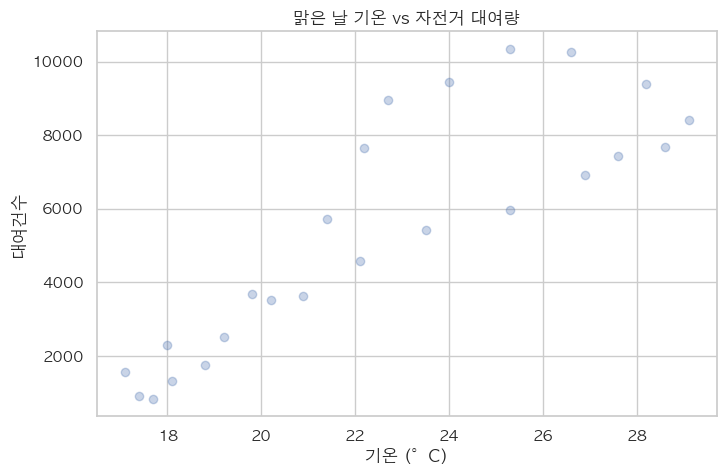

In [21]:
#산점도
plt.figure(figsize=(8, 5))
plt.scatter(df_temp['기온'], df_temp['대여건수'], alpha=0.3)
plt.xlabel('기온 (°C)')
plt.ylabel('대여건수')
plt.title('맑은 날 기온 vs 자전거 대여량')
plt.show()


[가설2] 주말 vs 평일 대여량
                  mean      sum
주말평일_최종                        
주말       116965.666667  1052691
평일       141505.904762  2971624


/var/folders/dd/f2k55d550k56jsv4rd7v1_3m0000gn/T/ipykernel_39764/4021835956.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=bike_daily, x='주말평일_최종', y='대여건수', estimator='mean', ci=None, alpha=0.7)


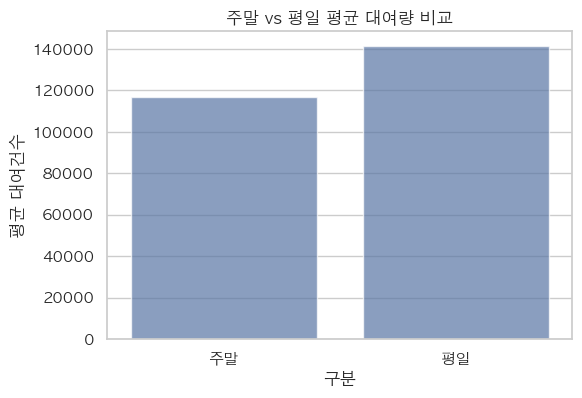

In [26]:
#==============================
#4. 가설2: 주말 vs 평일 대여량
#==============================

# 1.날짜별 대여량 집계
bike_daily = (
    merged_df.groupby('날짜')['대여건수']
    .sum()
    .reset_index()
)

# 2️.주말/평일 정보 병합 (중복 제거)
bike_daily = pd.merge(
    bike_daily,
    merged_df[['날짜', '주말평일_최종']].drop_duplicates(),
    on='날짜',
    how='left'
)

# 3️. 주말/평일별 평균 및 합계 계산
result_week = bike_daily.groupby('주말평일_최종')['대여건수'].agg(['mean', 'sum'])

print("\n[가설2] 주말 vs 평일 대여량")
print(result_week)

# 4️. 시각화
plt.figure(figsize=(6,4))
sns.barplot(data=bike_daily, x='주말평일_최종', y='대여건수', estimator='mean', ci=None, alpha=0.7)
plt.title('주말 vs 평일 평균 대여량 비교')
plt.xlabel('구분')
plt.ylabel('평균 대여건수')
plt.show()


In [30]:
#==============================
# 5. 가설3: 시간대별 대여량   
#==============================
agg_time = bike_df.groupby('시간대')['대여건수'].agg(['mean', 'sum'])
print("\n[가설3] 시간대별 대여량")
print(agg_time)


[가설3] 시간대별 대여량
      mean      sum
시간대                
야간     1.0  1445139
주간     1.0  1407463
출근시간   1.0   492566
퇴근시간   1.0   679147


In [ ]:
#==============================
# 1) classify_time 함수
def classify_time(hour):
    try:
        hour = int(hour)
    except:
        return '알수없음'
    if 7 <= hour < 9:
        return '출근시간'
    elif 17 <= hour < 19:
        return '퇴근시간'
    elif 9 <= hour < 17:
        return '주간'
    else:
        return '야간'

# 2) bike_df에 '시간' 컬럼이 없으면 시도해서 생성 
if '시간' not in bike_df.columns:
    if '대여일시' in bike_df.columns:
        bike_df['대여일시'] = pd.to_datetime(bike_df['대여일시'], errors='coerce')
        bike_df['날짜'] = bike_df['대여일시'].dt.date
        bike_df['시간'] = bike_df['대여일시'].dt.hour
    else:
        raise RuntimeError("bike_df에 '시간' 또는 '대여일시' 둘 다 없습니다. 먼저 시간 추출이 필요합니다.")

# 3) bike_df에 '시간대'가 없으면 생성
if '시간대' not in bike_df.columns:
    bike_df['시간대'] = bike_df['시간'].apply(classify_time)

# 4) 날짜+시간 단위로 정확히 집계(시간대 포함)
#    이렇게 하면 '대여건수'가 시간대별로 합쳐진 값으로 나오고, mean이 1로 고정되는 문제 해결
bike_agg = (
    bike_df.groupby(['날짜', '시간', '시간대', '주말평일_최종'], dropna=False)
    .size()
    .reset_index(name='대여건수')
)

# 5) 만약 merged_df를 만들 계획이면 bike_agg를 사용해 병합
#    (weather_merge는 날짜,시간,기온,... 포함된 전처리된 날씨프레임)
if 'weather_merge' in globals():
    merged_df = pd.merge(
        bike_agg,
        weather_merge,            # weather_merge should have '날짜' + '시간'
        on=['날짜', '시간'],
        how='left'
    )
else:
    # weather_merge가 없으면 bike_agg 만으로 분석 가능
    merged_df = bike_agg.copy()

# 6) 디버그: 컬럼 확인
print("bike_df columns:", bike_df.columns.tolist())
print("bike_agg columns:", bike_agg.columns.tolist())
print("merged_df columns:", merged_df.columns.tolist())
print("샘플 (bike_agg):")
print(bike_agg.head())


bike_df columns: ['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호', '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '생년', '성별', '이용자종류', '대여대여소ID', '반납대여소ID', '자전거구분', '날짜', '시간', '요일', '월', '요일명', '주말평일', '날짜_str', '공휴일', '주말평일_최종', '대여건수', '시간대']
bike_agg columns: ['날짜', '시간', '시간대', '주말평일_최종', '대여건수']
merged_df columns: ['날짜', '시간', '시간대', '주말평일_최종', '대여건수', '기온', '강수량', '풍속', '습도', '날씨상태']
샘플 (bike_agg):
           날짜  시간 시간대 주말평일_최종  대여건수
0  2025-06-01   0  야간      주말  3691
1  2025-06-01   1  야간      주말  2514
2  2025-06-01   2  야간      주말  1747
3  2025-06-01   3  야간      주말  1335
4  2025-06-01   4  야간      주말   841



[가설3] 평일/주말 시간대별 대여현황:
                      mean     sum
주말평일_최종 시간대                       
주말      야간     3722.758333  446731
        주간     6396.875000  511750
        출근시간   2961.750000   59235
        퇴근시간   8644.500000  172890
평일      야간     4160.033333  998408
        주간     5598.206250  895713
        출근시간  10833.275000  433331
        퇴근시간  12656.425000  506257


/var/folders/dd/f2k55d550k56jsv4rd7v1_3m0000gn/T/ipykernel_39764/1271461465.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


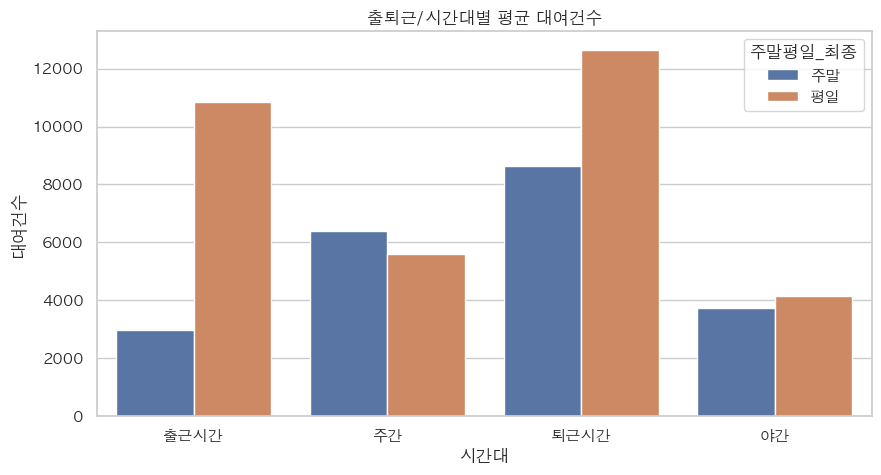

In [33]:
# 가설3: 시간대별 대여량 (주말/평일 구분 포함)
# merged_df에 이미 '주말평일_최종'과 '시간대'가 포함돼 있으므로 바로 집계 가능
result_time = (
    merged_df.groupby(['주말평일_최종', '시간대'])['대여건수']
    .agg(['mean', 'sum'])
    .sort_index()
)

print("\n[가설3] 평일/주말 시간대별 대여현황:")
print(result_time)

# 시각화: 평균 대여건수 비교
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(
    data=merged_df,
    x='시간대', y='대여건수', hue='주말평일_최종',
    estimator='mean', ci=None,
    order=['출근시간','주간','퇴근시간','야간']
)
plt.title('출퇴근/시간대별 평균 대여건수')
plt.show()
